# Create a star WAM

A star WAM should have one point (just imagine its the first one) which is connected to all the other points. However, all the other points should only be connected back to that first point. 

In [3]:
function create_star_wam(N::Int, σ::Float64, μ::Float64=1.0)
    A = zeros(Float64, N, N)

    for i in 2:N
        rnd = μ + σ * randn()
        A[1, i] = rnd
        A[i, 1] = rnd
    end

    return A

end

am = create_star_wam(10, 0.001, 1.0)

10×10 Matrix{Float64}:
 0.0       0.998463  0.999354  0.999983  …  0.999285  0.999353  0.998464
 0.998463  0.0       0.0       0.0          0.0       0.0       0.0
 0.999354  0.0       0.0       0.0          0.0       0.0       0.0
 0.999983  0.0       0.0       0.0          0.0       0.0       0.0
 1.0012    0.0       0.0       0.0          0.0       0.0       0.0
 0.999665  0.0       0.0       0.0       …  0.0       0.0       0.0
 0.998978  0.0       0.0       0.0          0.0       0.0       0.0
 0.999285  0.0       0.0       0.0          0.0       0.0       0.0
 0.999353  0.0       0.0       0.0          0.0       0.0       0.0
 0.998464  0.0       0.0       0.0          0.0       0.0       0.0

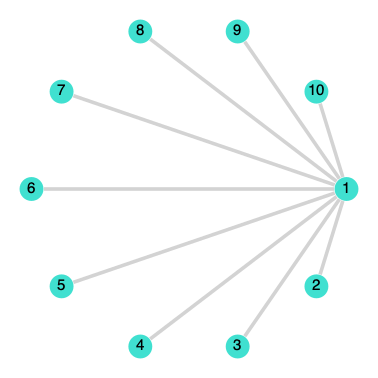

In [4]:
using GraphPlot
using Graphs
import Cairo, Fontconfig

function plot_am(adj_mat; layout_type::String = "circular")
    """
    Plot the graph represented by the adjacency matrix.

    layout_type can be "circular", "spring", "spectral", or "random".
    """
    # Validate layout type
    valid_layouts = ["circular", "spring", "spectral", "random"]
    if !(layout_type in valid_layouts)
        error("Invalid layout type. Choose from: $(join(valid_layouts, ", "))")
    end

    # Map layout type to corresponding function
    layout_lookup = Dict(
        "circular" => circular_layout,
        "spring" => spring_layout,
        "spectral" => spectral_layout,
        "random" => random_layout
    )

    # Create a simple graph from the adjacency matrix
    G = Graphs.SimpleGraph(adj_mat)

    # Generate node labels
    node_labels = map(string, 1:size(adj_mat, 1))

    # Plot the graph with the specified layout
    return GraphPlot.gplot(
        G,
        layout=layout_lookup[layout_type],
        nodelabel=node_labels,
        nodesize=0.3,
        nodelabelsize=3,
        edgelinewidth=2.0
    )
end

# Example usage
plot_am(am)

# Finding the reduced density matricies between pairs

The goal is to compute $\rho_{ij}$, which is the density matrix for sites $i$ and $j$ only. This is defined by tracing out i.e. ignoring all other sites in the full systems density matrix $\rho=\ket{\psi}

In [9]:
using ITensors, ITensorMPS
using LinearAlgebra

function compute_reduced_density_matrix(psi::MPS, sites, i::Int, j::Int)
    """
    Compute the reduced density matrix for any two sites using SVD decomposition.
    This is the mathematically correct method that properly traces out all other sites.
    """
    
    # Ensure i < j
    if i > j
        i, j = j, i
    end
    
    N = length(sites)
    
    # Step 1: Move the orthogonality center to between sites i and j
    mid_point = div(i + j, 2)
    orthogonalize!(psi, mid_point)
    
    # Step 2: Group sites into three regions: [1...i-1], [i,j], [j+1...N]
    
    # Contract all tensors from 1 to i-1 (left environment)
    if i > 1
        left_env = psi[1]
        for k = 2:(i-1)
            left_env = left_env * psi[k]
        end
    else
        left_env = ITensor(1.0)  # Identity tensor if no left sites
    end
    
    # Contract tensors i and j (the subsystem of interest)
    if j == i + 1
        # Adjacent case
        center = psi[i] * psi[j]
    else
        # Non-adjacent: contract all sites from i to j
        center = psi[i]
        for k = (i+1):j
            center = center * psi[k]
        end
    end
    
    # Contract all tensors from j+1 to N (right environment) 
    if j < N
        right_env = psi[j+1]
        for k = (j+2):N
            right_env = right_env * psi[k]
        end
    else
        right_env = ITensor(1.0)  # Identity tensor if no right sites
    end
    
    # Step 3: Contract environments to trace out unwanted degrees of freedom
    # This gives us the effective wavefunction for the i,j subsystem
    
    # Contract left environment
    if i > 1
        center = left_env * center
    end
    
    # Contract right environment  
    if j < N
        center = center * right_env
    end
    
    # Step 4: Form the reduced density matrix
    # Extract the physical indices for sites i and j
    s_i = sites[i]
    s_j = sites[j]
    
    # Form ρ = |center⟩⟨center|
    rho_tensor = center * dag(prime(center, s_i, s_j))
    
    # Convert to matrix form
    C_rows = combiner(s_i, s_j)
    C_cols = combiner(prime(s_i), prime(s_j))
    
    rho_combined = (rho_tensor * C_rows) * dag(C_cols)
    rho_matrix = matrix(rho_combined)
    
    return Array(rho_matrix)
end

compute_reduced_density_matrix (generic function with 1 method)

Let's test this.

In [12]:
using Test

@testset "Reduced Density Matrix Tests" begin
    # Test 1: Simple product state |↑⟩|↓⟩
    sites = siteinds("S=1/2", 2)
    init_state = ["Up", "Dn"]  # Simple product state |↑⟩|↓⟩
    ψ_simple = MPS(sites, init_state)

    # Compute the reduced density matrix for sites 1 and 2
    ρ_simple = compute_reduced_density_matrix(ψ_simple, sites, 1, 2)
    
    # Check basic properties
    @test isapprox(tr(ρ_simple), 1.0, atol=1e-10)  # Trace = 1
    @test isapprox(ρ_simple, ρ_simple', atol=1e-10)  # Hermitian
    
    # Check that it's a pure state (only one eigenvalue = 1)
    eigenvals = real(eigvals(ρ_simple))
    sort!(eigenvals, rev=true)
    @test isapprox(eigenvals[1], 1.0, atol=1e-10)  # Largest eigenvalue = 1
    @test all(abs.(eigenvals[2:end]) .< 1e-10)     # All others = 0
    
    # Test 2: Bell state (|↑↓⟩ + |↓↑⟩)/√2 - should give non-diagonal ρ
    
    # Create Bell state manually using ITensors
    s1, s2 = sites[1], sites[2]
    
    # Create the Bell state: (|↑↓⟩ + |↓↑⟩)/√2
    up_dn = MPS(sites, ["Up", "Dn"])
    dn_up = MPS(sites, ["Dn", "Up"])
    
    # Normalize each component
    normalize!(up_dn)
    normalize!(dn_up)
    
    # Create Bell state as linear combination
    bell_state = add(up_dn, dn_up)
    normalize!(bell_state)
    
    # Compute reduced density matrix
    ρ_bell = compute_reduced_density_matrix(bell_state, sites, 1, 2)
    
    display(ρ_bell)
    # Check basic properties
    @test isapprox(tr(ρ_bell), 1.0, atol=1e-10)  # Trace = 1
    @test isapprox(ρ_bell, ρ_bell', atol=1e-10)  # Hermitian
    
    # Check that it has off-diagonal elements (entanglement)
    off_diagonal_sum = sum(abs.(ρ_bell - Diagonal(diag(ρ_bell))))
    @test off_diagonal_sum > 1e-10  # Should have off-diagonal elements
    
    # FIXED: More flexible eigenvalue test
    eigenvals_bell = real(eigvals(ρ_bell))
    sort!(eigenvals_bell, rev=true)
    
    # For a pure Bell state: one eigenvalue = 1, others = 0
    # For a mixed Bell state: two eigenvalues = 0.5, others = 0
    # Either is acceptable for an entangled state
    num_nonzero_eigenvals = sum(eigenvals_bell .> 1e-10)
    @test num_nonzero_eigenvals >= 1  # At least one non-zero eigenvalue
    @test isapprox(sum(eigenvals_bell), 1.0, atol=1e-10)  # Eigenvalues sum to 1
    
    # Compute concurrence for Bell state (should be 1.0)
    C_bell = compute_concurrence(ρ_bell)
    @test isapprox(C_bell, 1.0, atol=1e-10)  # Perfect entanglement
end

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.5  0.5  0.0
 0.0  0.5  0.5  0.0
 0.0  0.0  0.0  0.0

Test Summary:                | Pass  Total  Time
Reduced Density Matrix Tests |   10     10  0.4s


Test.DefaultTestSet("Reduced Density Matrix Tests", Any[], 10, false, false, true, 1.762626968873246e9, 1.762626969256768e9, false, "In[12]")

# Create a test state and find the concurrence.

Just find a random ground state, and see if we can get the concurrence.

In [14]:
function create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
    """Create the XXZ Hamiltonian as an MPO given an adjacency matrix."""
    ampo = OpSum()
    for i = 1:N-1
        for j = i+1:N
            weight = adj_mat[i, j]
            if weight != 0.0
                # XX and YY terms: S+S- + S-S+ = 2(SxSx + SySy)
                # So to get J(SxSx + SySy), we need J/2 * (S+S- + S-S+)
                ampo += weight * J/2, "S+", i, "S-", j
                ampo += weight * J/2, "S-", i, "S+", j
                # ZZ term
                ampo += weight * J * Δ, "Sz", i, "Sz", j
            end
        end
    end
    H = MPO(ampo, sites)
    return H
end 

function solve_xxz_hamiltonian_dmrg(H, ψ0, sweeps::Int=10, bond_dim::Int=1000, cutoff::Float64=1E-14)
    """Solves the XXZ Hamiltonian using DMRG with given parameters. Returns the ground state energy and MPS. """
    swps = Sweeps(sweeps)
    setmaxdim!(swps, bond_dim)
    setcutoff!(swps, cutoff)
    E, ψ = dmrg(H, ψ0, swps; outputlevel=0)
    return E, ψ # only ground state and ground state wavefunction
end

function create_MPS(L::Int, conserve_qns::Bool=true)
    """Create a random MPS for a spin-1/2 chain of length L with bond dimension Χ."""
    # create a site set for a spin-1/2 chain
    sites = siteinds("S=1/2", L; conserve_qns=conserve_qns) # conserve total Sz

    # create a random MPS with bond dimension Χ
    init_state = [isodd(i) ? "Up" : "Dn" for i = 1:L] # antiferromagnetic ground state
    # THIS IS IMPORTANT - SEE NOTE BELOW
    # it sets the subspace of states we are allowed to explore
    # for example, this init_state means we only explore states with total Sz = 0 (i.e. zero magnetisation)
    # this is a reasonable assumption for positive J, but not for negative J
    # if we want to explore ferromagnetic states (negative J), we would need a different init_state
    # USE create_custom_MPS TO SET A DIFFERENT INIT STATE
    ψ0 = MPS(sites, init_state)
    return ψ0, sites
end

create_MPS (generic function with 2 methods)

In [15]:
J = -1
Δ = -1

N = 10

σ = 0.002
μ = 1.0

NUM_SWEEPS = 30
MAX_BOND_DIM = 500

500

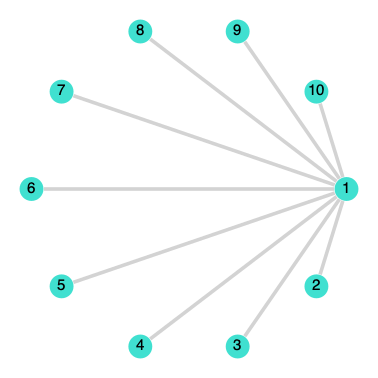

10

In [16]:
ψ_mps, sites = create_MPS(N)  # Example for a 10-site system
wam = create_star_wam(N, σ, μ)
display(plot_am(wam))
H = create_xxz_hamiltonian_mpo(N, wam, J, Δ, sites)
_, ψ_gs = solve_xxz_hamiltonian_dmrg(H, ψ_mps, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
bond_dim = maxlinkdim(ψ_gs)


For now just consider sites 1 and 2

In [17]:
ρ = compute_reduced_density_matrix(ψ_gs, sites, 1, 2)
println("Reduced density matrix for sites 1 and 2:")
display(ρ)
println("Trace: ", tr(ρ))
println("Is Hermitian: ", isapprox(ρ, ρ', atol=1e-10))

Reduced density matrix for sites 1 and 2:


4×4 Matrix{Float64}:
 0.222331  0.0       0.0       0.0
 0.0       0.277669  0.277669  0.0
 0.0       0.277669  0.277669  0.0
 0.0       0.0       0.0       0.222331

Trace: 0.9999999999999993
Is Hermitian: true


In [18]:
using LinearAlgebra

function compute_concurrence(ρ)
    # Define the Pauli-Y matrix
    σ_y = [0 -im; im 0]

    # Compute the spin-flip operator (σ_y ⊗ σ_y)
    spin_flip = kron(σ_y, σ_y)

    # Compute the spin-flipped density matrix: ρ_tilde = spin_flip * conj(ρ) * spin_flip
    ρ_tilde = spin_flip * conj(ρ) * spin_flip

    # Compute R = ρ * ρ_tilde
    R = ρ * ρ_tilde

    # Compute the eigenvalues of R
    λ = eigvals(R)

    λ_real = real(λ)
    λ_clamped = max.(λ_real, 0.0)
    # Sort eigenvalues in descending order
    λ_sorted = sort(λ_clamped, rev=true)

    # Compute the concurrence
    C = max(0, sqrt(λ_sorted[1]) - sqrt(λ_sorted[2]) - sqrt(λ_sorted[3]) - sqrt(λ_sorted[4]))

    return C
end

compute_concurrence (generic function with 1 method)

In [19]:
concurrence_12 = compute_concurrence(ρ)
println("Concurrence between sites 1 and 2: ", concurrence_12)

Concurrence between sites 1 and 2: 0.11067697015999835


# Replotting the graphs with concurrence along edges

Let's see if we can replot the graph with concurrence along the edges, so we can see where the entanglement comes in.

In [22]:
using Statistics

function plot_graph_with_concurrence(adj_mat, psi_gs, sites; layout_type::String = "circular")
    
    # Validate layout type
    valid_layouts = ["circular", "spring", "spectral", "random"]
    if !(layout_type in valid_layouts)
        error("Invalid layout type. Choose from: $(join(valid_layouts, ", "))")
    end

    # Map layout type to corresponding function
    layout_lookup = Dict(
        "circular" => circular_layout,
        "spring" => spring_layout,
        "spectral" => spectral_layout,
        "random" => random_layout
    )

    N = size(adj_mat, 1)
    
    # Create COMPLETE graph (all possible edges)
    complete_adj = ones(N, N) - I(N)  # All pairs except self-connections
    G_complete = Graphs.SimpleGraph(complete_adj)
    
    # Compute concurrence for ALL pairs
    println("Computing concurrence for ALL pairs...")
    edge_concurrences = Float64[]
    edge_colors = String[]
    connected_pairs = 0
    unconnected_pairs = 0

    for i in 1:N-1
        for j in i+1:N
            # Compute RDM and concurrence for this pair
            ρ_ij = compute_reduced_density_matrix(psi_gs, sites, i, j)
            C_ij = compute_concurrence(ρ_ij)
            
            push!(edge_concurrences, C_ij)
            
            # Determine color based on whether it's in the adjacency matrix
            if adj_mat[i, j] != 0.0
                push!(edge_colors, "green")  # Physical connection
                connected_pairs += 1
                println("Edge ($i, $j) [CONNECTED]:    Concurrence = $(round(C_ij, digits=4))")
            else
                push!(edge_colors, "grey")      # No physical connection
                unconnected_pairs += 1
                println("Edge ($i, $j) [UNCONNECTED]: Concurrence = $(round(C_ij, digits=4))")
            end
        end
    end
    
    # Map concurrence to line thickness
    min_thickness = 0.3
    max_thickness = 4.0
    
    function concurrence_to_thickness(c::Float64)
        c = clamp(c, 0.0, 1.0)
        return min_thickness + c * (max_thickness - min_thickness)
    end
    
    # Convert concurrences to thicknesses
    edge_thicknesses = [concurrence_to_thickness(c) for c in edge_concurrences]
    
    # Generate node labels
    node_labels = map(string, 1:N)
    
    # Compute statistics
    max_concurrence = maximum(edge_concurrences)
    min_concurrence = minimum(edge_concurrences)
    avg_concurrence = mean(edge_concurrences)
    
    # Separate statistics for connected vs unconnected
    connected_indices = [i for (i, color) in enumerate(edge_colors) if color == "darkblue"]
    unconnected_indices = [i for (i, color) in enumerate(edge_colors) if color == "grey"]
    
    connected_concurrences = edge_concurrences[connected_indices]
    unconnected_concurrences = edge_concurrences[unconnected_indices]
    
    println("Total pairs: $(length(edge_concurrences))")
    println("Connected pairs (green): $connected_pairs")
    println("Unconnected pairs (grey): $unconnected_pairs")
    println()
    
    if length(connected_concurrences) > 0
        println("CONNECTED PAIRS:")
        println("  Max concurrence: $(round(maximum(connected_concurrences), digits=4))")
        println("  Avg concurrence: $(round(mean(connected_concurrences), digits=4))")
        println("  Entangled (C > 0.01): $(sum(connected_concurrences .> 0.01))")
    end
    
    if length(unconnected_concurrences) > 0
        println("UNCONNECTED PAIRS:")
        println("  Max concurrence: $(round(maximum(unconnected_concurrences), digits=4))")
        println("  Avg concurrence: $(round(mean(unconnected_concurrences), digits=4))")
        println("  Entangled (C > 0.01): $(sum(unconnected_concurrences .> 0.01))")
    end
    
    # Plot the complete graph with color-coded and thickness-coded edges
    return GraphPlot.gplot(
        G_complete,
        layout=layout_lookup[layout_type],
        nodelabel=node_labels,
        nodesize=0.4,
        nodelabelsize=3,
        edgelinewidth=edge_thicknesses,  # Thickness = concurrence
        edgestrokec=edge_colors,         # Blue = connected, Grey = unconnected
        nodestrokec="black",
        nodefillc="lightblue"
    )
end

plot_graph_with_concurrence (generic function with 1 method)

Computing concurrence for ALL pairs...
Edge (1, 2) [CONNECTED]:    Concurrence = 0.1107
Edge (1, 3) [CONNECTED]:    Concurrence = 0.1117
Edge (1, 4) [CONNECTED]:    Concurrence = 0.1113
Edge (1, 5) [CONNECTED]:    Concurrence = 0.1124
Edge (1, 6) [CONNECTED]:    Concurrence = 0.111
Edge (1, 7) [CONNECTED]:    Concurrence = 0.1111
Edge (1, 8) [CONNECTED]:    Concurrence = 0.1104
Edge (1, 9) [CONNECTED]:    Concurrence = 0.1108
Edge (1, 10) [CONNECTED]:    Concurrence = 0.1108
Edge (2, 3) [UNCONNECTED]: Concurrence = 0.1111
Edge (2, 4) [UNCONNECTED]: Concurrence = 0.1111
Edge (2, 5) [UNCONNECTED]: Concurrence = 0.111
Edge (2, 6) [UNCONNECTED]: Concurrence = 0.1112
Edge (2, 7) [UNCONNECTED]: Concurrence = 0.1112
Edge (2, 8) [UNCONNECTED]: Concurrence = 0.1113
Edge (2, 9) [UNCONNECTED]: Concurrence = 0.1112
Edge (2, 10) [UNCONNECTED]: Concurrence = 0.1112
Edge (3, 4) [UNCONNECTED]: Concurrence = 0.111
Edge (3, 5) [UNCONNECTED]: Concurrence = 0.1109
Edge (3, 6) [UNCONNECTED]: Concurrence = 

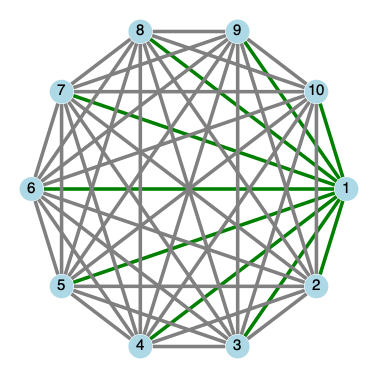

In [46]:
# adj_mat, psi_gs, sites; layout_type::String = "circular"

g = plot_graph_with_concurrence(wam, ψ_gs, sites)
display(g)
using Compose
draw(PNG("star_conc_graph.png", 16cm, 12cm), g)

This is interesting! It looks like the central node is acting as a kind of hub of entanglement. 

Let's quickly see if this happens for a chain as well.

In [24]:
function generate_chain_wam(N::Int, σ::Float64; μ::Float64=1.0)
    """
    Create a weighted adjacency matrix for a 1D chain with N nodes and nearest-neighbor connections only.
    Weights are drawn from a normal distribution with mean μ and standard deviation σ.
    """

    adj_mat = zeros(Float64, N, N)
    
    # connect each node to its nearest neighbors with weights
    for i in 1:N-1
        weight = μ + σ * randn() # weight from normal distribution with mean μ and std σ
        adj_mat[i, i+1] = weight  # Connect i to i+1
        adj_mat[i+1, i] = weight  # Connect i+1 to i (make symmetric)
    end
    
    return adj_mat
end

generate_chain_wam (generic function with 1 method)

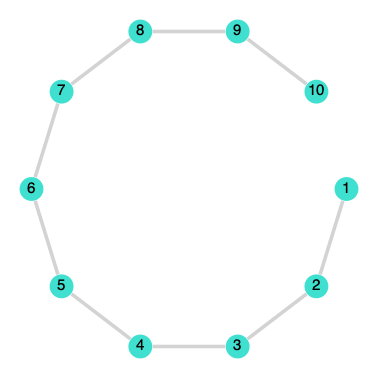

20

In [25]:
ψ_mps_chain, sites_chain = create_MPS(N)  # Example for a 10-site system
wam_chain = generate_chain_wam(N, σ; μ)
display(plot_am(wam_chain))
H_chain = create_xxz_hamiltonian_mpo(N, wam_chain, J, Δ, sites_chain)
_, ψ_gs_chain = solve_xxz_hamiltonian_dmrg(H_chain, ψ_mps_chain, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
bond_dim_chain = maxlinkdim(ψ_gs_chain)

Computing concurrence for ALL pairs...
Edge (1, 2) [CONNECTED]:    Concurrence = 0.8176
Edge (1, 3) [UNCONNECTED]: Concurrence = 0.0
Edge (1, 4) [UNCONNECTED]: Concurrence = 0.0
Edge (1, 5) [UNCONNECTED]: Concurrence = 0.0
Edge (1, 6) [UNCONNECTED]: Concurrence = 0.0
Edge (1, 7) [UNCONNECTED]: Concurrence = 0.0
Edge (1, 8) [UNCONNECTED]: Concurrence = 0.0
Edge (1, 9) [UNCONNECTED]: Concurrence = 0.0
Edge (1, 10) [UNCONNECTED]: Concurrence = 0.0
Edge (2, 3) [CONNECTED]:    Concurrence = 0.0743
Edge (2, 4) [UNCONNECTED]: Concurrence = 0.0
Edge (2, 5) [UNCONNECTED]: Concurrence = 0.0
Edge (2, 6) [UNCONNECTED]: Concurrence = 0.0
Edge (2, 7) [UNCONNECTED]: Concurrence = 0.0
Edge (2, 8) [UNCONNECTED]: Concurrence = 0.0
Edge (2, 9) [UNCONNECTED]: Concurrence = 0.0
Edge (2, 10) [UNCONNECTED]: Concurrence = 0.0
Edge (3, 4) [CONNECTED]:    Concurrence = 0.6585
Edge (3, 5) [UNCONNECTED]: Concurrence = 0.0
Edge (3, 6) [UNCONNECTED]: Concurrence = 0.0
Edge (3, 7) [UNCONNECTED]: Concurrence = 0.0
Ed

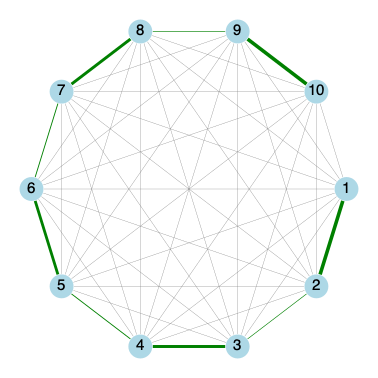

In [48]:
g = plot_graph_with_concurrence(wam_chain, ψ_gs_chain, sites_chain)
display(g)
using Compose
draw(PNG("chain_conc_graph.png", 16cm, 12cm), g)

Yes! We see we get much smaller entanglement between non-adjecent nodes. The star system is more "highly entangled".

In [27]:
using Plots

function plot_concurrence_heatmap(adj_mat, psi_gs, sites; title_suffix="")
    
    N = size(adj_mat, 1)
    
    # Initialize concurrence matrix
    concurrence_matrix = zeros(Float64, N, N)
    
    println("Computing all pairwise concurrences...")
    
    # Compute concurrence for all pairs
    for i in 1:N
        for j in 1:N
            if i == j
                # Diagonal: no self-entanglement
                concurrence_matrix[i, j] = 0.0
            elseif i < j
                # Compute concurrence for pair (i,j)
                ρ_ij = compute_reduced_density_matrix(psi_gs, sites, i, j)
                C_ij = compute_concurrence(ρ_ij)
                concurrence_matrix[i, j] = C_ij
                concurrence_matrix[j, i] = C_ij  # Symmetric
                
            end
        end
    end
    
    # Create the heatmap
    p = heatmap(concurrence_matrix,
                xlabel="Site j",
                ylabel="Site i", 
                title="Concurrence Heatmap $title_suffix",
                color=:viridis,
                aspect_ratio=:equal,
                size=(400, 400))
    
    # Add site labels
    plot!(p, xticks=1:N, yticks=1:N)
    
    # Add colorbar title
    plot!(p, colorbar_title="Concurrence")
    
    return p, concurrence_matrix
end

plot_concurrence_heatmap (generic function with 1 method)

Computing all pairwise concurrences...


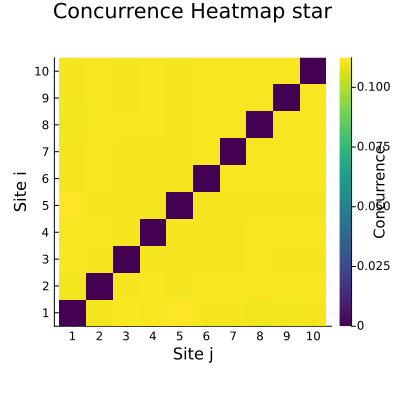

"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/james/star_representation/star_conc_heatmap.png"

In [61]:
heatmap_star, matrix_star = plot_concurrence_heatmap(wam, ψ_gs, sites; title_suffix="star")
display(heatmap_star)
savefig(heatmap_star, "star_conc_heatmap.png")

Computing all pairwise concurrences...


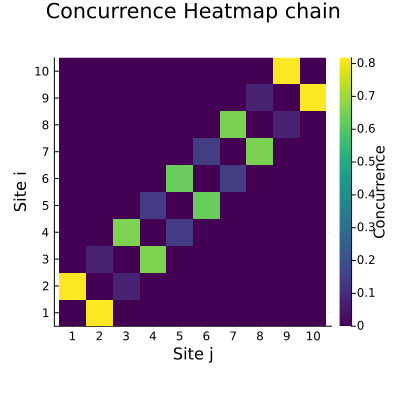

"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/james/star_representation/chain_conc_heatmap.png"

In [60]:
heatmap_chain, matrix_chain = plot_concurrence_heatmap(wam_chain, ψ_gs_chain, sites_chain; title_suffix="chain")
display(heatmap_chain)
savefig(heatmap_chain, "chain_conc_heatmap.png")

# How does the entanglement change as we vary the system size (star).

We want to look at how the entanglement between the central node and any other node changes as we increase the system size. We expect this to follow a 
$$
c = \frac{1}{N-1}
$$
curve, since the entanglement simply has to be shared over more systems. 

In [131]:
using Plots

ITensors.set_warn_order(16)

N_range = 2:1:15
J = -1
Δ = -1
σ = 0.000

c_vals = []
for N in N_range
    ψ_mps_N, sites_N = create_MPS(N)
    wam_N = create_star_wam(N, σ, μ)
    H_N = create_xxz_hamiltonian_mpo(N, wam_N, J, Δ, sites_N)
    _, ψ_gs_N = solve_xxz_hamiltonian_dmrg(H_N, ψ_mps_N, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
    
    ρ_N = compute_reduced_density_matrix(ψ_gs_N, sites_N, 1, 2)
    c_N = compute_concurrence(ρ_N)
    push!(c_vals, c_N)
    println("N = $N: Concurrence = $(round(c_N, digits=4))")

end

# plotting...

plt = plot(collect(N_range), c_vals, 
     xlabel="System Size (N)", 
     ylabel="Concurrence", 
     title="Concurrence vs System Size for Star System", 
     marker=:circle,
     markersize=5,
     linewidth=2,
     color=:blue,
     label="Star (1-2)")

# Corrected theoretical curve: 1/(N-1)
theoretical_curve = 1 ./ (collect(N_range) .- 1)
plot!(collect(N_range), theoretical_curve, 
      linestyle=:dash, 
      color=:red, 
      linewidth=2,
      label="1/(N-1) theoretical")

plot!(legend=:topright, grid=true)

savefig(plt, "concurrence_vs_system_size.png")
    

N = 2: Concurrence = 1.0
N = 3: Concurrence = 0.6667
N = 4: Concurrence = 0.3333
N = 5: Concurrence = 0.2536
N = 3: Concurrence = 0.6667
N = 4: Concurrence = 0.3333
N = 5: Concurrence = 0.2536
N = 6: Concurrence = 0.2
N = 7: Concurrence = 0.1674
N = 6: Concurrence = 0.2
N = 7: Concurrence = 0.1674
N = 8: Concurrence = 0.1429
N = 8: Concurrence = 0.1429
N = 9: Concurrence = 0.1252
N = 9: Concurrence = 0.1252
N = 10: Concurrence = 0.1111
N = 10: Concurrence = 0.1111
N = 11: Concurrence = 0.1001
N = 11: Concurrence = 0.1001
N = 12: Concurrence = 0.0909
N = 12: Concurrence = 0.0909
N = 13: Concurrence = 0.0834
N = 13: Concurrence = 0.0834
N = 14: Concurrence = 0.0769
N = 14: Concurrence = 0.0769
N = 15: Concurrence = 0.0715
N = 15: Concurrence = 0.0715


"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/james/star_representation/concurrence_vs_system_size.png"

We see the behaviour that we expect. Except for one thing. Why does the 3 atom case cause problems?

It might be to do with the 3 state being notoriously hard to satisfy.

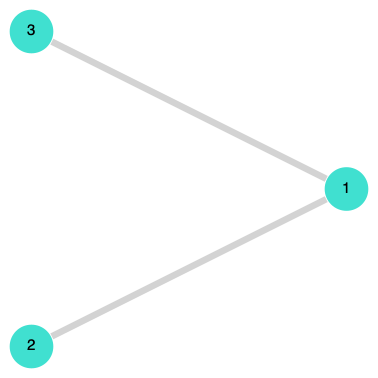

2

In [39]:
ψ_mps_3, sites_3 = create_MPS(3) 
wam_3 = create_star_wam(3, σ, μ)
display(plot_am(wam_3))
H_3 = create_xxz_hamiltonian_mpo(3, wam_3, J, Δ, sites_3)
_, ψ_gs_3 = solve_xxz_hamiltonian_dmrg(H_3, ψ_mps_3, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
maxlinkdim(ψ_gs_3)

See that we have a bond dimension of 2! This means the ground state is entangled, and so the entanglement can't just be shared across the two variables.

In [132]:
# find the bond dimension of the star ground state mps
N_range = 2:1:15
J = -1
Δ = -1
σ = 0.000

chi_vals = []
for N in N_range
    ψ_mps_N, sites_N = create_MPS(N)
    wam_N = create_star_wam(N, σ, μ)
    H_N = create_xxz_hamiltonian_mpo(N, wam_N, J, Δ, sites_N)
    _, ψ_gs_N = solve_xxz_hamiltonian_dmrg(H_N, ψ_mps_N, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
    
    push!(chi_vals, maxlinkdim(ψ_gs_N))
end

# plot

plt = plot(collect(N_range), chi_vals, 
     xlabel="System Size (N)", 
     ylabel="Bond Dimension of Ground State MPS", 
     title="Bond dim with system size", 
     marker=:circle,
     markersize=5,
     linewidth=2,
     color=:blue)

savefig(plt, "bond_dim_with_system_size.png")

"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/james/star_representation/bond_dim_with_system_size.png"

# Fully connected Graphs with disorder

Let's see what happens when we have fully connected graphs with some disorder introduced. Do we get "pockets" of entanglement?

Let's just do it with one at first.

In [51]:
function generate_fully_connected_wam(N::Int, σ::Float64; μ::Float64=1.0)
    """
    Create a weighted adjacency matrix for a fully connected graph of N nodes. μ should always be one really.
    """
 
    A = zeros(Float64, N, N)
    for i in 1:N
        for j in (i+1):N
            weight = μ + σ * randn() # weight from normal distribution with mean μ and std σ
            A[i, j] = weight
            A[j, i] = weight 
        end
    end
    return A
end 

generate_fully_connected_wam (generic function with 1 method)

In [62]:
N = 10
σ = 0.002

0.002

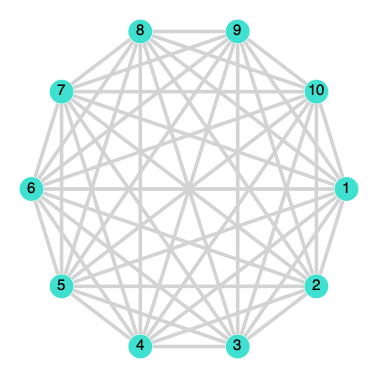

(-13.751416607932436, MPS
[1] ((dim=2|id=77|"Link,l=1") <Out>
 1: QN("Sz",-1) => 1
 2: QN("Sz",1) => 1, (dim=2|id=351|"S=1/2,Site,n=1") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1)
[2] ((dim=4|id=687|"Link,l=2") <Out>
 1: QN("Sz",-2) => 1
 2: QN("Sz",0) => 2
 3: QN("Sz",2) => 1, (dim=2|id=863|"S=1/2,Site,n=2") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=77|"Link,l=1") <In>
 1: QN("Sz",-1) => 1
 2: QN("Sz",1) => 1)
[3] ((dim=2|id=881|"S=1/2,Site,n=3") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=8|id=750|"Link,l=3") <Out>
 1: QN("Sz",-3) => 1
 2: QN("Sz",-1) => 3
 3: QN("Sz",1) => 3
 4: QN("Sz",3) => 1, (dim=4|id=687|"Link,l=2") <In>
 1: QN("Sz",-2) => 1
 2: QN("Sz",0) => 2
 3: QN("Sz",2) => 1)
[4] ((dim=2|id=779|"S=1/2,Site,n=4") <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=14|id=292|"Link,l=4") <Out>
 1: QN("Sz",-4) => 1
 2: QN("Sz",-2) => 4
 3: QN("Sz",0) => 4
 4: QN("Sz",2) => 4
 5: QN("Sz",4) => 1, (dim=8|id=750|"Link,l=3") <In>
 1: QN("Sz",-3) => 1

In [63]:
ψ_mps_fc, sites_fc = create_MPS(N)  # Example for a 10-site system
wam_fc = generate_fully_connected_wam(N, σ; μ)
display(plot_am(wam_fc))
H_fc = create_xxz_hamiltonian_mpo(N, wam_fc, J, Δ, sites_fc)
_, ψ_gs_fc = solve_xxz_hamiltonian_dmrg(H_fc, ψ_mps_fc, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)

Computing concurrence for ALL pairs...
Edge (1, 2) [CONNECTED]:    Concurrence = 0.1112
Edge (1, 3) [CONNECTED]:    Concurrence = 0.1112
Edge (1, 4) [CONNECTED]:    Concurrence = 0.111
Edge (1, 5) [CONNECTED]:    Concurrence = 0.1112
Edge (1, 6) [CONNECTED]:    Concurrence = 0.1111
Edge (1, 7) [CONNECTED]:    Concurrence = 0.111
Edge (1, 8) [CONNECTED]:    Concurrence = 0.1115
Edge (1, 9) [CONNECTED]:    Concurrence = 0.111
Edge (1, 10) [CONNECTED]:    Concurrence = 0.1107
Edge (2, 3) [CONNECTED]:    Concurrence = 0.111
Edge (2, 4) [CONNECTED]:    Concurrence = 0.1111
Edge (2, 5) [CONNECTED]:    Concurrence = 0.1113
Edge (2, 6) [CONNECTED]:    Concurrence = 0.111
Edge (2, 7) [CONNECTED]:    Concurrence = 0.1112
Edge (2, 8) [CONNECTED]:    Concurrence = 0.1109
Edge (2, 9) [CONNECTED]:    Concurrence = 0.111
Edge (2, 10) [CONNECTED]:    Concurrence = 0.1113
Edge (3, 4) [CONNECTED]:    Concurrence = 0.111
Edge (3, 5) [CONNECTED]:    Concurrence = 0.1111
Edge (3, 6) [CONNECTED]:    Concurr

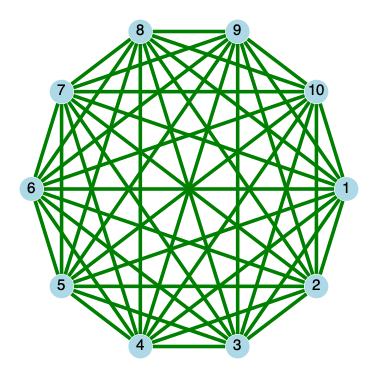

In [64]:
g = plot_graph_with_concurrence(wam_fc, ψ_gs_fc, sites_fc)
display(g)
using Compose
draw(PNG("fc_conc_graph.png", 16cm, 12cm), g)

Computing all pairwise concurrences...


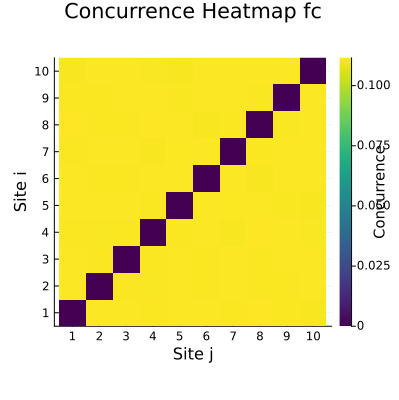

"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/james/star_representation/fc_conc_heatmap.png"

In [65]:
heatmap_fc, matrix_fc = plot_concurrence_heatmap(wam_fc, ψ_gs_fc, sites_fc; title_suffix="fc")
display(heatmap_fc)
savefig(heatmap_fc, "fc_conc_heatmap.png")

Let's see how sites 1 and two entangle with system size. We should expect similar behaviour to the star maybe.

In [58]:
c_vals = []
for N in N_range
    ψ_mps_N, sites_N = create_MPS(N)  # Example for a 10-site system
    wam_N = generate_fully_connected_wam(N, σ; μ)
    H_N = create_xxz_hamiltonian_mpo(N, wam_N, J, Δ, sites_N)
    _, ψ_gs_N = solve_xxz_hamiltonian_dmrg(H_N, ψ_mps_N, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
    
    ρ_N = compute_reduced_density_matrix(ψ_gs_N, sites_N, 1, 2)
    c_N = compute_concurrence(ρ_N)
    push!(c_vals, c_N)
    println("N = $N: Concurrence = $(round(c_N, digits=4))")
end

plt = plot(collect(N_range), c_vals, 
     xlabel="System Size (N)", 
     ylabel="Concurrence", 
     title="Concurrence vs System Size for FC System", 
     marker=:circle,
     markersize=5,
     linewidth=2,
     color=:blue,
     label="FC (1-2)")

# Corrected theoretical curve: 1/(N-1)
theoretical_curve = 1 ./ (collect(N_range) .- 1)
plot!(collect(N_range), theoretical_curve, 
      linestyle=:dash, 
      color=:red, 
      linewidth=2,
      label="1/(N-1) theoretical")

plot!(legend=:topright, grid=true)

savefig(plt, "fc_conc_heatmap.png")

N = 2: Concurrence = 1.0
N = 3: Concurrence = 0.6792
N = 4: Concurrence = 0.3399
N = 5: Concurrence = 0.2544
N = 6: Concurrence = 0.199
N = 7: Concurrence = 0.1671
N = 8: Concurrence = 0.1488
N = 9: Concurrence = 0.124
N = 10: Concurrence = 0.1132
N = 11: Concurrence = 0.1016
N = 12: Concurrence = 0.0888
N = 13: Concurrence = 0.0829
N = 14: Concurrence = 0.0787
N = 15: Concurrence = 0.0723


"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/james/star_representation/fc_conc_heatmap.png"

In [133]:
# Compare star vs fully-connected
Ns_fc = [res.N for res in results_fc]
Ns_star = [res.N for res in results]

avg_conc_fc = [res.avg_all_concurrence for res in results_fc]
avg_conc_star = [res.avg_central_concurrence for res in results]

max_bd_fc = [res.max_bond_dim for res in results_fc]
max_bd_star = [res.max_bond_dim for res in results]

# Plot 1: Average concurrence comparison
p_conc_compare = plot(Ns_star, avg_conc_star, 
                      label="Star (site 1)", 
                      xlabel="System Size N", 
                      ylabel="Average Concurrence",
                      title="Monogamy Effect: Star vs Fully Connected",
                      marker=:circle, linewidth=2)
plot!(Ns_fc, avg_conc_fc, 
      label="Fully Connected (all pairs)", 
      marker=:square, linewidth=2)
plot!(Ns_star, 1 ./ (Ns_star .- 1), 
      label="1/(N-1) theoretical", 
      linestyle=:dash, linewidth=2)

display(p_conc_compare)

# Plot 2: Bond dimension comparison
p_bd_compare = plot(Ns_star, log2.(max_bd_star), 
                    label="Star", 
                    xlabel="System Size N", 
                    ylabel="log₂(Max Bond Dim)",
                    title="Bipartite Entanglement: Star vs Fully Connected",
                    marker=:circle, linewidth=2)
plot!(Ns_fc, log2.(max_bd_fc), 
      label="Fully Connected", 
      marker=:square, linewidth=2)

display(p_bd_compare)

# Plot 3: Uniformity of entanglement (std dev)
std_fc = [res.std_concurrence for res in results_fc]
p_uniformity = plot(Ns_fc, std_fc,
                    xlabel="System Size N",
                    ylabel="Std Dev of Concurrence",
                    title="Entanglement Uniformity (FC graphs)",
                    marker=:circle, linewidth=2,
                    label="Fully Connected")

display(p_uniformity)

println("\nKey Observations:")
println("1. Is FC more monogamous than star? Compare avg concurrences")
println("2. Are FC bond dimensions lower? Compare log₂(χ)")
println("3. Is FC entanglement more uniform? Check std dev → 0")

LoadError: UndefVarError: `results_fc` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
# Analyze fully-connected graphs with same parameters
results_fc = []
N_range_fc = 3:1:12

for N in N_range_fc
    wam_fc = generate_fully_connected_wam(N, σ; μ)
    ψ_mps, sites = create_MPS(N)
    H = create_xxz_hamiltonian_mpo(N, wam_fc, J, Δ, sites)
    _, ψ_gs = solve_xxz_hamiltonian_dmrg(H, ψ_mps, 30, 500, 1e-10)
    
    # Compute all pairwise concurrences (not just from site 1)
    all_concurrences = []
    for i in 1:N-1
        for j in i+1:N
            ρ_ij = compute_reduced_density_matrix(ψ_gs, sites, i, j)
            C_ij = compute_concurrence(ρ_ij)
            push!(all_concurrences, C_ij)
        end
    end
    
    # Site 1 concurrences (for comparison with star)
    site1_concurrences = []
    for j in 2:N
        ρ_1j = compute_reduced_density_matrix(ψ_gs, sites, 1, j)
        C_1j = compute_concurrence(ρ_1j)
        push!(site1_concurrences, C_1j)
    end
    
    bond_dims = [linkdim(ψ_gs, i) for i in 1:N-1]
    
    push!(results_fc, (N=N,
                       all_concurrences=all_concurrences,
                       site1_concurrences=site1_concurrences,
                       avg_all_concurrence=mean(all_concurrences),
                       avg_site1_concurrence=mean(site1_concurrences),
                       std_concurrence=std(all_concurrences),
                       max_bond_dim=maximum(bond_dims),
                       bond_dims=bond_dims))
end

println("Fully-connected analysis complete!")

# Fully Connected Graphs: Extreme Monogamy

Your supervisor emphasizes that fully-connected graphs should show **even stronger monogamy effects** than star graphs. Why?

- **Star graph**: Central spin couples to N-1 spins
- **Fully connected**: EVERY spin couples to N-1 spins

If one spin already struggles to share entanglement with N-1 partners, imagine when ALL spins face the same constraint! The system should form an RVB state where entanglement is even more diluted.

**Prediction:** 
- Lower average concurrence than star graphs
- Lower bond dimensions
- More uniform entanglement pattern (all pairs equally weakly entangled)

# Site Monogamy

We want to check if sites are monogamous in entanglement - that is, do they have a "limit" to how much entanglement they can "give out"? We want to check the idea that entanglement is a limited supply.

In [134]:
N = 10
σ = 0.0

0.0

First we generate star graphs for each $N$. We can then find 
- the concurrence between the central node (1) and every other node
- the bond dimensions for each cut in the graph (i.e. bipartitate entanglement)

To see how the cuts work, imagine we have sites `[1, 2, 3, 4]`. Then, we can make the cuts
- `[1] | [2, 3, 4]`
- `[1, 2] | [3, 4]`
- `[1, 2, 3] | [4]`

which preserve the linear ordering of the sites.

In [137]:

results = []
N_range = 3:1:12

for N in N_range
    wam_star = create_star_wam(N, σ, 1.0) 
    ψ_mps, sites = create_MPS(N)
    H = create_xxz_hamiltonian_mpo(N, wam_star, -1, -1, sites)
    _, ψ_gs = solve_xxz_hamiltonian_dmrg(H, ψ_mps, 30, 500, 1e-10)
    
    # find all the concurrences between 1 and all other sites
    central_concurrences = []
    for j in 2:N
        ρ_1j = compute_reduced_density_matrix(ψ_gs, sites, 1, j)
        C_1j = compute_concurrence(ρ_1j)
        push!(central_concurrences, C_1j)
    end
    
    # compute bipartite entanglement across different cuts (i.e. bond dim)
    bond_dims = [linkdim(ψ_gs, i) for i in 1:N-1]
    
    push!(results, (N=N, 
                    central_concurrences=central_concurrences,
                    avg_central_concurrence=mean(central_concurrences),
                    total_central_entanglement=sum(central_concurrences),
                    max_bond_dim=maximum(bond_dims),
                    bond_dims=bond_dims))
end




Look at the $N=4$ results. We see that we get bond dims 2, 3 and 2 (corresponding to the cuts above).

It is a common feature of quantum systems: when the system is divided into two groups of equal size, the entanglement entropy (and hence bond dimension) tends to be higher because the two groups share more correlations.

To see this, consider all the pairwise ways for two equal groups of two sites: $2\times2=4$. But, when it is a group of one and a group of three: $1\times 3 = 3$.

## Monogamy Analysis

We want to check if the spins prefer monogamy.

### Monogamy limit

We can check the entanglement distribution between the central node and all the others. In theory, if we take the sum of its concurrence with the other nodes, this should be bounded if we are in a monogamous system.

In [138]:
for res in results
    N = res.N
    concurrences = res.central_concurrences
    
    # Key monogamy tests
    squared_sum = sum(concurrences.^2)  
    linear_sum = sum(concurrences)       
    theoretical = 1/(N-1)
    
    println("N=$N:")
    println("  Individual C1j^2: ", [round(c, digits=3) for c in concurrences])
    println("  Average C1j: $(round(mean(concurrences), digits=3)) (theory: $(round(theoretical, digits=3)))")
    println("  Linear sum ΣC1j: $(round(linear_sum, digits=3))")
    println("  Squared sum ΣC1j: $(round(squared_sum, digits=3))")
    println("  Max bond dim χmax: $(res.max_bond_dim)")
    println("  Bond dims: $(res.bond_dims)")
    println()
end

N=3:
  Individual C1j^2: [0.667, 0.667]
  Average C1j: 0.667 (theory: 0.5)
  Linear sum ΣC1j: 1.333
  Squared sum ΣC1j: 0.889
  Max bond dim χmax: 2
  Bond dims: [2, 2]

N=4:
  Individual C1j^2: [0.333, 0.333, 0.333]
  Average C1j: 0.333 (theory: 0.333)
  Linear sum ΣC1j: 1.0
  Squared sum ΣC1j: 0.333
  Max bond dim χmax: 3
  Bond dims: [2, 3, 2]

N=5:
  Individual C1j^2: [0.254, 0.254, 0.254, 0.254]
  Average C1j: 0.254 (theory: 0.25)
  Linear sum ΣC1j: 1.014
  Squared sum ΣC1j: 0.257
  Max bond dim χmax: 3
  Bond dims: [2, 3, 3, 2]

N=6:
  Individual C1j^2: [0.2, 0.2, 0.2, 0.2, 0.2]
  Average C1j: 0.2 (theory: 0.2)
  Linear sum ΣC1j: 1.0
  Squared sum ΣC1j: 0.2
  Max bond dim χmax: 4
  Bond dims: [2, 3, 4, 3, 2]

N=7:
  Individual C1j^2: [0.167, 0.167, 0.167, 0.167, 0.167, 0.167]
  Average C1j: 0.167 (theory: 0.167)
  Linear sum ΣC1j: 1.004
  Squared sum ΣC1j: 0.168
  Max bond dim χmax: 4
  Bond dims: [2, 3, 4, 4, 3, 2]

N=8:
  Individual C1j^2: [0.143, 0.143, 0.143, 0.143, 0.143, 0.

## Effective Entanglement

Now we can look at how the entanglement is distributed across different cuts in the system.

We have 
- **bond dimension** $\chi$: bipartite entanglement accross the cut.
- **number of pairs crossing the cut**: the number of spin pairs contributing to the entanglement across the cut. This is equal to the number of sites on the right of the cut that the central node connects to. In this situation, where the central node is spin 1, this is just equal to the number of nodes on the right of the cut.
- **average concurrence**: average pairwise entanglement between the central node and the other nodes.

The effective entanglement is just the number of pairs crossing the cut multiplied by the average concurrence. This is an estimate for the entanglement 'flowing across the cut'.

In [139]:
println("\n" * "=" ^ 60)
println("LINKING PAIRWISE TO BIPARTITE ENTANGLEMENT")
println("=" ^ 60)

# For each system, look at the middle cut
for res in results
    N = res.N
    middle_cut = div(N, 2)  # Cut approximately in the middle
    
    if middle_cut < length(res.bond_dims)
        χ_middle = res.bond_dims[middle_cut]
        avg_conc = res.avg_central_concurrence
        
        # How many pairs cross this cut?
        # Central spin (site 1) is on the left if middle_cut ≥ 1
        if middle_cut >= 1
            # Central is on left, counts pairs to all spins on right
            pairs_crossing = N - middle_cut
        end
        
        # Effective entanglement crossing the cut
        effective_ent = pairs_crossing * avg_conc
        
        # Compare to actual bond dimension
        S_actual = log2(χ_middle)
        S_predicted = log2(1 + effective_ent * 2)  # Rough estimate
        
        @printf("N=%2d (cut at %2d): ", N, middle_cut)
        @printf("χ=%3d, ", χ_middle)
        @printf("Pairs=%2d, ", pairs_crossing)
        @printf("C_avg=%5.3f, ", avg_conc)
        @printf("Eff_Ent=%5.3f, ", effective_ent)
        @printf("S_actual=%5.3f\n", S_actual)
    end
end

println("=" ^ 60)


LINKING PAIRWISE TO BIPARTITE ENTANGLEMENT
N= 3 (cut at  1): χ=  2, Pairs= 2, C_avg=0.667, Eff_Ent=1.333, S_actual=1.000
N= 4 (cut at  2): χ=  3, Pairs= 2, C_avg=0.333, Eff_Ent=0.667, S_actual=1.585
N= 5 (cut at  2): χ=  3, Pairs= 3, C_avg=0.254, Eff_Ent=0.761, S_actual=1.585
N= 6 (cut at  3): χ=  4, Pairs= 3, C_avg=0.200, Eff_Ent=0.600, S_actual=2.000
N= 7 (cut at  3): χ=  4, Pairs= 4, C_avg=0.167, Eff_Ent=0.669, S_actual=2.000
N= 8 (cut at  4): χ=  5, Pairs= 4, C_avg=0.143, Eff_Ent=0.571, S_actual=2.322
N= 9 (cut at  4): χ=  5, Pairs= 5, C_avg=0.125, Eff_Ent=0.626, S_actual=2.322
N=10 (cut at  5): χ=  6, Pairs= 5, C_avg=0.111, Eff_Ent=0.556, S_actual=2.585
N=11 (cut at  5): χ=  6, Pairs= 6, C_avg=0.100, Eff_Ent=0.601, S_actual=2.585
N=12 (cut at  6): χ=  7, Pairs= 6, C_avg=0.091, Eff_Ent=0.545, S_actual=2.807
Pairs= 2, C_avg=0.667, Eff_Ent=1.333, S_actual=1.000
N= 4 (cut at  2): χ=  3, Pairs= 2, C_avg=0.333, Eff_Ent=0.667, S_actual=1.585
N= 5 (cut at  2): χ=  3, Pairs= 3, C_avg=0.25

In [140]:
using Printf

println("=" ^ 60)
println("MONOGAMY INEQUALITY TEST")
println("=" ^ 60)

for res in results
    N = res.N
    concurrences = res.central_concurrences
    
    # Compute squared sum (LHS of inequality)
    squared_sum = sum(concurrences.^2)
    
    # For a bipartite cut [1] | [2,...,N], the bond dimension at position 1 
    # gives us the entanglement entropy: S = log2(χ)
    χ_at_1 = res.bond_dims[1]  # Cut after site 1
    S_bipartite = log2(χ_at_1)
    
    # The tangle (RHS of inequality) relates to entropy
    # For pure states: C²(1, rest) ≈ some function of S
    # Upper bound: C² ≤ 1 (maximum)
    tangle_estimate = min(1.0, (χ_at_1 - 1) / χ_at_1)  # Normalized measure
    
    # Check if monogamy holds
    monogamy_satisfied = squared_sum ≤ 1.0  # Conservative bound
    
    @printf("N=%2d: ", N)
    @printf("ΣC²=%5.3f, ", squared_sum)
    @printf("χ₁=%2d, ", χ_at_1)
    @printf("S=%5.3f, ", S_bipartite)
    @printf("Monogamy: %s\n", monogamy_satisfied ? "✓" : "✗")
end

println("=" ^ 60)

MONOGAMY INEQUALITY TEST
N= 3: ΣC²=0.889, χ₁= 2, S=1.000, Monogamy: ✓
N= 4: ΣC²=0.333, χ₁= 2, S=1.000, Monogamy: ✓
N= 5: ΣC²=0.257, χ₁= 2, S=1.000, Monogamy: ✓
N= 6: ΣC²=0.200, χ₁= 2, S=1.000, Monogamy: ✓
N= 7: ΣC²=0.168, χ₁= 2, S=1.000, Monogamy: ✓
N= 8: ΣC²=0.143, χ₁= 2, S=1.000, Monogamy: ✓
N= 9: ΣC²=0.125, χ₁= 2, S=1.000, Monogamy: ✓
N=10: ΣC²=0.111, χ₁= 2, S=1.000, Monogamy: ✓
N=11: ΣC²=0.100, χ₁= 2, S=1.000, Monogamy: ✓
N=12: ΣC²=0.091, χ₁= 2, S=1.000, Monogamy: ✓
χ₁= 2, S=1.000, Monogamy: ✓
N= 4: ΣC²=0.333, χ₁= 2, S=1.000, Monogamy: ✓
N= 5: ΣC²=0.257, χ₁= 2, S=1.000, Monogamy: ✓
N= 6: ΣC²=0.200, χ₁= 2, S=1.000, Monogamy: ✓
N= 7: ΣC²=0.168, χ₁= 2, S=1.000, Monogamy: ✓
N= 8: ΣC²=0.143, χ₁= 2, S=1.000, Monogamy: ✓
N= 9: ΣC²=0.125, χ₁= 2, S=1.000, Monogamy: ✓
N=10: ΣC²=0.111, χ₁= 2, S=1.000, Monogamy: ✓
N=11: ΣC²=0.100, χ₁= 2, S=1.000, Monogamy: ✓
N=12: ΣC²=0.091, χ₁= 2, S=1.000, Monogamy: ✓


## Testing Monogamy Inequality

The CKW (Coffman-Kundu-Wootters) monogamy inequality states that for a central spin entangled with N-1 others:

$$\sum_{j=2}^{N} C_{1j}^2 \leq C_{1,\{2,...,N\}}^2$$

where the right side is the "tangle" (squared concurrence) between spin 1 and the entire rest of the system. For a bipartite split, this tangle equals the entanglement entropy, which relates to bond dimension via:

$$S = \log_2(\chi)$$

Let's verify this inequality holds and explore the connection.

In [141]:
for res in results
    N = res.N
    bond_dims = res.bond_dims
    avg_conc = res.avg_central_concurrence
    
    print("N=$N")

    # where is the central spin relative to the cuts
    for (cut, χ) in enumerate(bond_dims)

        # [1, 2, 3] | [4, 5, 6, 7, 8]
        # left_size = 3, this is where we say the cut happens

        left_size = cut 
        right_size = N - cut

        central_on_left = (cut >= 1)  # Central spin is at position 1
        # ** for position 1, this is actually always true (cut is at least 1)
        
        # how many spin-pairs cross this cut
        if central_on_left
            pairs_crossing = right_size  # Central connects to all on right
        else
            pairs_crossing = left_size   # Central connects to all on left
        end
        
        # Effective entanglement crossing this cut
        effective_ent = pairs_crossing * avg_conc
        
        println("   Cut after site $cut:")
        println("   Bond dim χ = $χ, Pairs crossing cut: $pairs_crossing")
        println("   Avg concurrence: $(round(avg_conc, digits=3)), Effective entanglement: $(round(effective_ent, digits=3))")
        println("   log2(χ): $(round(log2(χ), digits=2))")
        println()
    end
end


N=3   Cut after site 1:
   Bond dim χ = 2, Pairs crossing cut: 2
   Avg concurrence: 0.667, Effective entanglement: 1.333
   log2(χ): 1.0

   Cut after site 2:
   Bond dim χ = 2, Pairs crossing cut: 1
   Avg concurrence: 0.667, Effective entanglement: 0.667
   log2(χ): 1.0

N=4   Cut after site 1:
   Bond dim χ = 2, Pairs crossing cut: 3
   Avg concurrence: 0.333, Effective entanglement: 1.0
   log2(χ): 1.0

   Cut after site 2:
   Bond dim χ = 3, Pairs crossing cut: 2
   Avg concurrence: 0.333, Effective entanglement: 0.667
   log2(χ): 1.58

   Cut after site 3:
   Bond dim χ = 2, Pairs crossing cut: 1
   Avg concurrence: 0.333, Effective entanglement: 0.333
   log2(χ): 1.0

N=5   Cut after site 1:
   Bond dim χ = 2, Pairs crossing cut: 4
   Avg concurrence: 0.254, Effective entanglement: 1.014
   log2(χ): 1.0

   Cut after site 2:
   Bond dim χ = 3, Pairs crossing cut: 3
   Avg concurrence: 0.254, Effective entanglement: 0.761
   log2(χ): 1.58

   Cut after site 3:
   Bond dim χ = 3,

## Results

We can first of all see if our bond dimension scales with system size logarithmically.

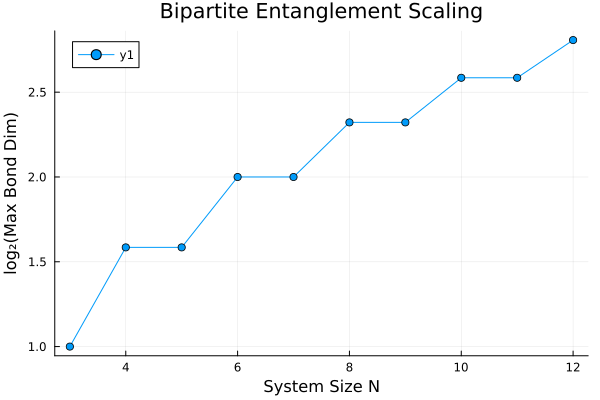

In [142]:
Ns = [res.N for res in results]
max_bond_dims = [res.max_bond_dim for res in results]

p1 = plot(Ns, log2.(max_bond_dims), 
            xlabel="System Size N", ylabel="log₂(Max Bond Dim)",
            title="Bipartite Entanglement Scaling", marker=:circle)

It seems to roughly follow a linear line [NEEDS MORE WORK].

We then have our familiar pairwise entanglement graph from before.

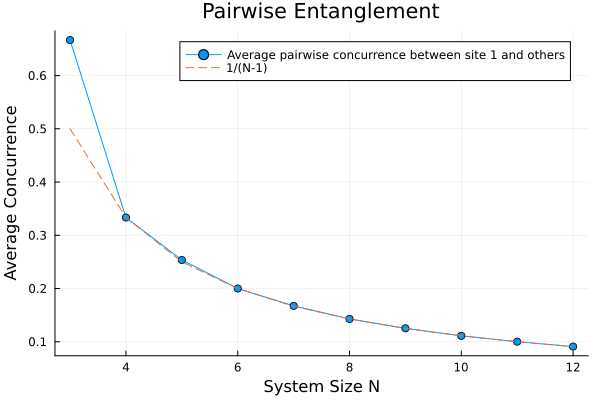

In [143]:
avg_concurrences = [res.avg_central_concurrence for res in results]

p2 = plot(Ns, avg_concurrences, 
            xlabel="System Size N", ylabel="Average Concurrence",
            title="Pairwise Entanglement", marker=:circle, label="Average pairwise concurrence between site 1 and others")
plot!(Ns, 1 ./ (Ns .- 1), linestyle=:dash, label="1/(N-1)")

Then we can see how the total entanglement scales with system size. If we are right about monogamy, we should expect it to not scale with system size, and tend to one. 

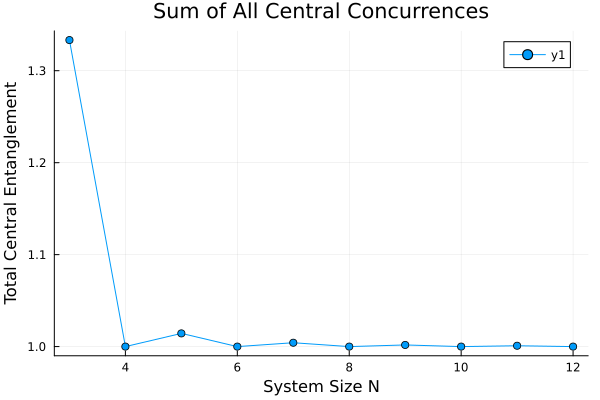

In [144]:
total_entanglements = [res.total_central_entanglement for res in results]

p3 = plot(Ns, total_entanglements,
            xlabel="System Size N", ylabel="Total Central Entanglement", 
            title="Sum of All Central Concurrences", marker=:circle)

$N=3$ is still problematic. We should explain this.

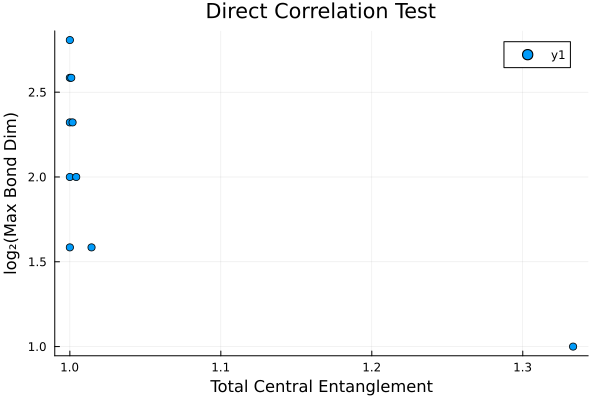

In [145]:
p4 = scatter(total_entanglements, log2.(max_bond_dims),
            xlabel="Total Central Entanglement", ylabel="log₂(Max Bond Dim)",
            title="Direct Correlation Test")

We can look at the max bond dim (which we assume is for the middle cut) vs the average concurrence.

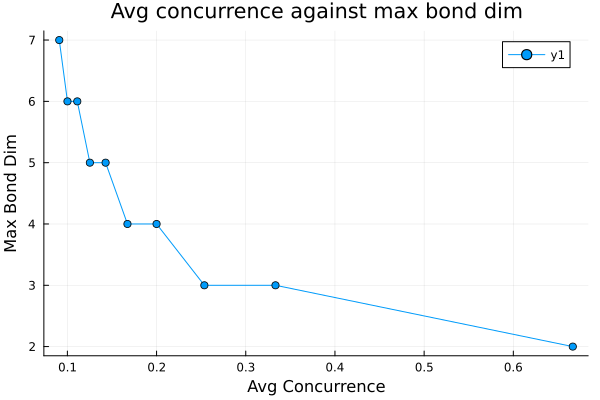

In [146]:
p5 = plot(avg_concurrences, max_bond_dims,
        ylabel="Max Bond Dim",
        xlabel="Avg Concurrence",
        title="Avg concurrence against max bond dim",
        marker=:circle
        )

We definately see a relationship.

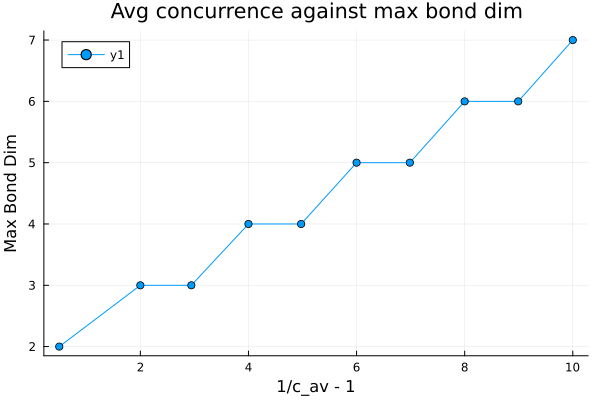

In [147]:
pred_ns = 1 ./avg_concurrences .- 1

p6 = plot(pred_ns, max_bond_dims,
        ylabel="Max Bond Dim",
        xlabel="1/c_av - 1",
        title="Avg concurrence against max bond dim",
        marker=:circle
        )

We get what looks like a linear dependance. And so, it makes sense to say that for small $N$, $\chi \propto N$ which is what we observe.

Fitted parameters: [1.576082936917008, 2.2329473421035164]
[1.576082936917008, 2.2329473421035164]


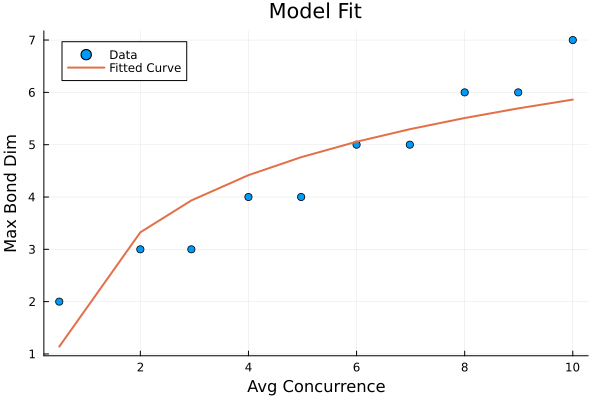

In [148]:
using LsqFit

# Define the data
x = pred_ns  # Average concurrence
y = max_bond_dims     # Max bond dimension

# Define a model function (e.g., polynomial or logarithmic)
# Example: y = a * log(x) + b
model(x, p) = p[1] * log.(x) .+ p[2]

# Initial parameter guesses
p0 = [1.0, 1.0]

# Perform the fit
fit = curve_fit(model, x, y, p0)

# Extract fitted parameters
println("Fitted parameters: ", fit.param)

# Plot the fitted curve
using Plots
scatter(x, y, label="Data", xlabel="Avg Concurrence", ylabel="Max Bond Dim", title="Model Fit")
plot!(x, model(x, fit.param), label="Fitted Curve", linewidth=2)

So we get roughly 

$$\chi = -2.4 \log_2(c_{av}) + 0.35$$

Then, if we say that 

$$c_{av} = \frac{1}{N-1}$$

then 

$$\chi = -2.4 \log_2 \left(\frac{1}{N-1} \right) + 0.35 = 2.4 \log_2(N-1) + 0.35$$

Let's test this hypothesis. We can run the data and see. 

Fitted parameters: [4.591425563157011, -6.420558680145967]
[4.591425563157011, -6.420558680145967]


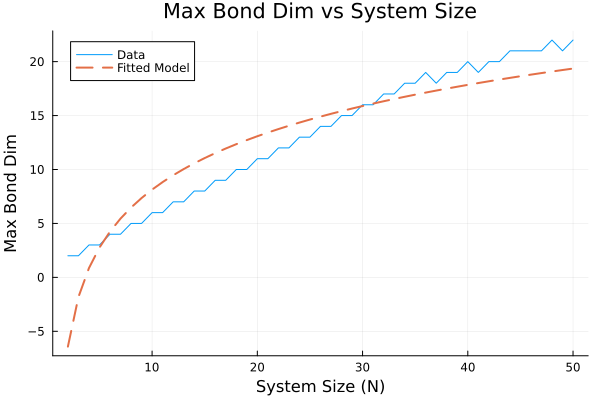

In [149]:
using LsqFit, Plots

# Parameters for the system
J = -1
Δ = -1
σ = 0.000
μ = 1.0
NUM_SWEEPS = 30
MAX_BOND_DIM = 500

# Function to compute max bond dimension for a given system size
function compute_max_bond_dim(N)
    ψ_mps, sites = create_MPS(N)
    wam = create_star_wam(N, σ, μ)
    H = create_xxz_hamiltonian_mpo(N, wam, J, Δ, sites)
    _, ψ_gs = solve_xxz_hamiltonian_dmrg(H, ψ_mps, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
    return maxlinkdim(ψ_gs)
end

# Compute max bond dimensions for N=2 to N=50
N_range = 2:50
max_bond_dims_long = [compute_max_bond_dim(N) for N in N_range]

# Fit the data against your derived model
# Model: χ = 2.4 * log2(N - 1) + 0.35
model(N, p) = p[1] * log2.(N .- 1) .+ p[2]
p0 = [2.4, 0.35]  # Initial guesses for parameters
fit = curve_fit(model, N_range, max_bond_dims_long, p0)

# Extract fitted parameters
println("Fitted parameters: ", fit.param)

# Plot the results
plot(N_range, max_bond_dims_long, label="Data", xlabel="System Size (N)", ylabel="Max Bond Dim", title="Max Bond Dim vs System Size")
plot!(N_range, model(N_range, fit.param), label="Fitted Model", linestyle=:dash, linewidth=2)

# Explicitly linking pairwise to bipartite entanlement

Let's check this explicitly just for the middle cut.

In [128]:
function analyze_entanglement_structure(wam, ψ_gs, sites)
    """
    Comprehensive analysis of both pairwise and bipartite entanglement.
    Returns a structured result with all entanglement measures.
    """
    N = size(wam, 1)
    
    # pairwise concurrences
    println("Computing pairwise concurrences...")
    pairwise_matrix = zeros(Float64, N, N)
    
    for i in 1:N-1
        for j in i+1:N
            ρ_ij = compute_reduced_density_matrix(ψ_gs, sites, i, j)
            C_ij = compute_concurrence(ρ_ij)
            pairwise_matrix[i, j] = C_ij
            pairwise_matrix[j, i] = C_ij
        end
    end
    
    # now bond dimensions over each possible cut
    println("Computing bipartite entanglement...")
    bond_dims = [linkdim(ψ_gs, i) for i in 1:N-1]
    # Bipartite entanglement entropy for each cut: S = log₂(χ)
    # This is the von Neumann entropy across the bipartite split
    bipartite_entropy = [log2(χ) for χ in bond_dims]
    
    # === ANALYSIS PER CUT ===
    cut_analysis = []
    for cut in 1:(N-1)
        left_sites = 1:cut
        right_sites = (cut+1):N
        
        # Count how many edges cross this cut
        edges_crossing = 0
        pairwise_ent_crossing = 0.0
        
        for i in left_sites
            for j in right_sites
                if wam[i, j] != 0.0  # Physical connection
                    edges_crossing += 1
                end
                # Add concurrence regardless of physical connection
                pairwise_ent_crossing += pairwise_matrix[i, j]
            end
        end
        
        # Number of possible pairs crossing (connecting ALL sites, not just interacting ones)
        possible_pairs = length(left_sites) * length(right_sites)
        avg_pairwise_crossing = pairwise_ent_crossing / possible_pairs
        
        push!(cut_analysis, (
            cut_position = cut,
            left_size = length(left_sites),
            right_size = length(right_sites),
            bond_dim = bond_dims[cut],
            bipartite_entropy = bipartite_entropy[cut],
            physical_edges_crossing = edges_crossing,
            total_pairs_crossing = possible_pairs,
            total_pairwise_ent = pairwise_ent_crossing,
            avg_pairwise_ent = avg_pairwise_crossing
        ))
    end
    
    return (
        N = N,
        pairwise_matrix = pairwise_matrix,
        bond_dims = bond_dims,
        bipartite_entropy = bipartite_entropy,
        max_bond_dim = maximum(bond_dims),
        max_bipartite_entropy = maximum(bipartite_entropy),
        cut_analysis = cut_analysis
    )
end

analyze_entanglement_structure (generic function with 1 method)

Now let's see how this bipartite entropy (bond dimension) scales with system size.

Analyzing N = 4...
Computing pairwise concurrences...
Computing bipartite entanglement...
N= 4: χ=  3, S_bipartite=1.585, Total C=1.333, Avg C=0.333, Pairs=  4
Analyzing N = 6...
Computing pairwise concurrences...Computing bipartite entanglement...
N= 4: χ=  3, S_bipartite=1.585, Total C=1.333, Avg C=0.333, Pairs=  4
Analyzing N = 6...
Computing pairwise concurrences...
Computing bipartite entanglement...
N= 6: χ=  4, S_bipartite=2.000, Total C=1.800, Avg C=0.200, Pairs=  9
Analyzing N = 8...
Computing pairwise concurrences...

Computing bipartite entanglement...
N= 6: χ=  4, S_bipartite=2.000, Total C=1.800, Avg C=0.200, Pairs=  9
Analyzing N = 8...
Computing pairwise concurrences...
Computing bipartite entanglement...
N= 8: χ=  5, S_bipartite=2.322, Total C=2.286, Avg C=0.143, Pairs= 16
Analyzing N = 10...
Computing pairwise concurrences...Computing bipartite entanglement...
N= 8: χ=  5, S_bipartite=2.322, Total C=2.286, Avg C=0.143, Pairs= 16
Analyzing N = 10...
Computing pairwise c

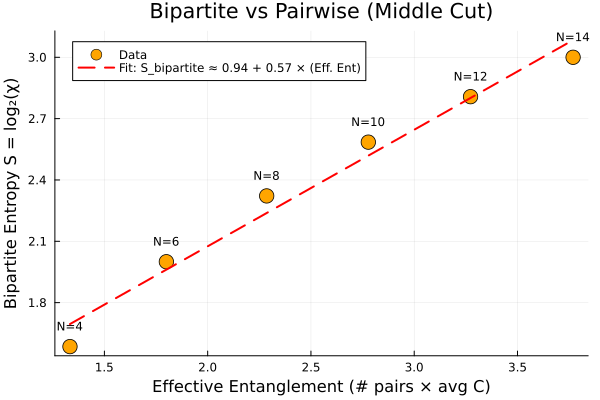

"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/james/star_representation/effective_entanglement_scaling.png"

In [129]:
# Analyze the middle cut for different system sizes
N_range_analysis = 4:2:14  # Even sizes for clean middle cuts
middle_cut_results = []

for N_test in N_range_analysis
    println("Analyzing N = $N_test...")
    
    # Generate system
    ψ_mps_test, sites_test = create_MPS(N_test)
    wam_test = generate_fully_connected_wam(N_test, σ; μ)
    H_test = create_xxz_hamiltonian_mpo(N_test, wam_test, J, Δ, sites_test)
    _, ψ_gs_test = solve_xxz_hamiltonian_dmrg(H_test, ψ_mps_test, NUM_SWEEPS, MAX_BOND_DIM, 1e-10)
    
    # Analyze
    result_test = analyze_entanglement_structure(wam_test, ψ_gs_test, sites_test)
    
    # Focus on middle cut
    middle_idx = div(N_test, 2)
    middle_cut_info = result_test.cut_analysis[middle_idx]
    
    push!(middle_cut_results, (
        N = N_test,
        chi_middle = middle_cut_info.bond_dim,
        S_bipartite_middle = middle_cut_info.bipartite_entropy,
        total_C_middle = middle_cut_info.total_pairwise_ent,
        avg_C_middle = middle_cut_info.avg_pairwise_ent,
        pairs_crossing = middle_cut_info.total_pairs_crossing
    ))
    
    @printf("N=%2d: χ=%3d, S_bipartite=%5.3f, Total C=%5.3f, Avg C=%5.3f, Pairs=%3d\n",
            N_test, middle_cut_info.bond_dim, middle_cut_info.bipartite_entropy,
            middle_cut_info.total_pairwise_ent, middle_cut_info.avg_pairwise_ent,
            middle_cut_info.total_pairs_crossing)
end

println("="^70)

# Extract data for plotting
Ns_scale = [r.N for r in middle_cut_results]
S_bipartite_scale = [r.S_bipartite_middle for r in middle_cut_results]
total_C_scale = [r.total_C_middle for r in middle_cut_results]
avg_C_scale = [r.avg_C_middle for r in middle_cut_results]
pairs_scale = [r.pairs_crossing for r in middle_cut_results]

effective_ent_scale = pairs_scale .* avg_C_scale

p_key = scatter(effective_ent_scale, S_bipartite_scale,
                xlabel="Effective Entanglement (# pairs × avg C)",
                ylabel="Bipartite Entropy S = log₂(χ)",
                title="Bipartite vs Pairwise (Middle Cut)",
                marker=:circle, markersize=8, label="Data",
                color=:orange, legend=:topleft)

for (i, N_val) in enumerate(Ns_scale)
    annotate!(p_key, effective_ent_scale[i], S_bipartite_scale[i] + 0.1, 
              text("N=$N_val", 8))
end

if length(effective_ent_scale) > 1
    A_fit = hcat(ones(length(effective_ent_scale)), effective_ent_scale)
    coeffs_fit = A_fit \ S_bipartite_scale
    fit_line = coeffs_fit[1] .+ coeffs_fit[2] .* sort(effective_ent_scale)
    plot!(p_key, sort(effective_ent_scale), fit_line,
          label="Fit: S_bipartite ≈ $(round(coeffs_fit[1], digits=2)) + $(round(coeffs_fit[2], digits=2)) × (Eff. Ent)",
          linestyle=:dash, linewidth=2, color=:red)
end

display(p_key)
savefig(p_key, "effective_entanglement_scaling.png")

## Scaling Analysis: How does the pairwise-bipartite relationship change with N?

Now let's see how this relationship evolves as we increase system size.